# Rules Extraction

# Statics

In [1]:
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.utils import Bunch
from sklearn.datasets._base import load_csv_data
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import csv

## Load Dataset

In [2]:
# Load Dataset
#iris
#dataset = load_iris()
target_value_name = 'class'

# Mushrooms
filename = 'mammographic_masses'
#list_of_continuous_columns = ["age"]
list_of_continuous_columns = []
number_of_divisions = 5
test_size = 0.2


data_file_name = f'../../../../data/{filename}.csv'
pandas_dataset = pd.read_csv(data_file_name)
pandas_dataset = pandas_dataset.replace('?', 'unknown')
pandas_dataset = pandas_dataset.dropna()
pandas_dataset.columns = [sub.replace('%', '') for sub in pandas_dataset.columns]
target_value_name = pandas_dataset.columns[-1]

pandas_dataset.columns = [sub.replace('-', '_').replace(' ', '').replace('class', 'target_value') for sub in pandas_dataset.columns]
target_value_name = pandas_dataset.columns[-1]
feature_names = pandas_dataset.columns[0:-1]


#dataset.feature_names = [sub.replace(' ', '').replace('(cm)', '') for sub in dataset.feature_names]

pandas_dataset.head()

,bi_rads,age,shape,margin,density,severity
0,5,67,3,5,3,1
1,4,43,1,1,unknown,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,unknown,1


# One Hot Encoding

In [3]:
from notebooks.IPRules.test_utils import continuous_to_discrete_column


def one_hot_encode_dataframe(data, feature_names):
    enc = OneHotEncoder(sparse_output=False)
    encoded_array = enc.fit_transform(data.loc[:,feature_names])
    encoded_feature_names = enc.get_feature_names_out()
    df_encoded = pd.DataFrame(encoded_array,columns=encoded_feature_names)
    encoded_pandas_dataset = pd.concat([df_encoded, data],axis=1)
    encoded_pandas_dataset.drop(labels= feature_names,axis=1,inplace=True)
    return encoded_pandas_dataset, encoded_feature_names

pandas_dataset = continuous_to_discrete_column(pandas_dataset,list_of_continuous_columns, number_of_divisions)
encoded_pandas_dataset, encoded_feature_names = one_hot_encode_dataframe(pandas_dataset, feature_names)
encoded_pandas_dataset.head()

,bi_rads_0,bi_rads_2,bi_rads_3,bi_rads_4,bi_rads_5,bi_rads_55,bi_rads_6,bi_rads_unknown,age_18,age_19,...,margin_3,margin_4,margin_5,margin_unknown,density_1,density_2,density_3,density_4,density_unknown,severity
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [4]:
X = encoded_pandas_dataset[encoded_feature_names]
y = encoded_pandas_dataset[target_value_name]

encoded_dataset = Bunch(
        data=X.to_numpy(),
        target=y.to_numpy(),
        target_names=target_value_name,
        feature_names=X.columns
)

#X_display = pandas_dataset.drop([target_value_name], axis=1)
#y_display = pandas_dataset[target_value_name]

#encoded_pandas_dataset = pd.DataFrame(data= np.c_[dataset['data'], dataset['target']], columns= list(dataset['feature_names']) + ['target'])
#encoded_pandas_dataset.head()


# Divide dataset

In [5]:
#Define dataset
X_train, X_test, y_train, y_test = train_test_split(encoded_dataset.data, encoded_dataset.target, test_size=test_size, random_state=1)
encoded_train_pandas_dataset = pd.DataFrame(data= np.c_[X_train, y_train], columns= list(encoded_dataset['feature_names']) + [target_value_name])
encoded_test_pandas_dataset = pd.DataFrame(data= np.c_[X_test, y_test], columns= list(encoded_dataset['feature_names']) + [target_value_name])
print()
print('Sizes (without target):')
print(f'Original size {encoded_dataset.data.shape}')
print(f'Train size {X_train.shape}')
print(f'Test size {X_test.shape}')


Sizes (without target):
Original size (961, 98)
Train size (768, 98)
Test size (193, 98)


## Define Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer, recall_score, accuracy_score

# Define scorer
ensemble = RandomForestClassifier(criterion="gini")
ensemble.fit(X_train, y_train)

RandomForestClassifier()

## iPRules

->Extract feature importance list


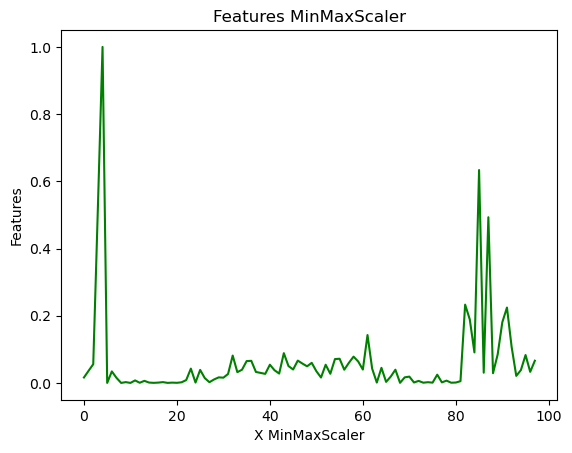

	 Original features 98
	 Selected features 30
	 Percentage of selected rules: 30.612244897959183 %
->Generate new tree based on list



KeyboardInterrupt



In [7]:
from iPRules.iPRules import iPRules

# initialize
rules = iPRules(
                feature_names=encoded_dataset.feature_names,
                target_value_name = encoded_dataset.target_names,
                display_features = True,
                display_logs = True,
                chi_square_percent_point_function = 0.95,
                scale_feature_coefficient = 0.05,
                min_accuracy_coefficient = 0.9,
                min_number_class_per_node = 1
            )
# Fit model
rules.fit(encoded_train_pandas_dataset, ensemble.feature_importances_)

# Print Model

In [ ]:
# DISPLAY DESCRIPTION
#print(rules.description())
# DISPLAY ALL RULES
print(rules)

# Predict

In [ ]:
# ENSEMBLE
y_pred_test_ensemble = ensemble.predict(X_test)

# RULES
y_pred_test_rules = rules.predict(X_test)

In [ ]:
# CATEGORIZABLES
np_array_rules = np.array(y_pred_test_rules)
#not_filter_indices = np.where(np.logical_and(np_array_rules != 0, np_array_rules!=1))[0]
filter_indices = np.where(np_array_rules != None)[0]


np_filterred_y_test = np.array(y_test)[filter_indices]
np_filterred_y_pred_test_ensemble = np.array(y_pred_test_ensemble)[filter_indices]
np_filterred_y_pred_test_rules = np.array(y_pred_test_rules)[filter_indices]
# CHANGE FORMAT IN ORDER TO NOT HAVE PROBLEMS
np_filterred_y_pred_test_rules = np_filterred_y_pred_test_rules.astype('int64')


print(f'DATASET TEST: {len(y_test)}')
print(f'DATASET TEST categorizable: {len(np_filterred_y_test)}')
print('Cobertura:',str("{:.2f}".format(100*(len(np_filterred_y_pred_test_rules)/len(y_test))))+'%')

ensemble_accuracy = metrics.accuracy_score(np_filterred_y_test, np_filterred_y_pred_test_ensemble)
print('RF accuracy:',str("{:.2f}".format(100*ensemble_accuracy))+'%')
ensemble_accuracy = metrics.f1_score(np_filterred_y_test, np_filterred_y_pred_test_ensemble)
print('RF F1-score:',str("{:.2f}".format(100*ensemble_accuracy))+'%')
rules_accuracy = metrics.accuracy_score(np_filterred_y_test, np_filterred_y_pred_test_rules)
print('Rules Accuracy:',str("{:.2f}".format(100*rules_accuracy))+'%')
rules_accuracy = metrics.f1_score(np_filterred_y_test, np_filterred_y_pred_test_rules)
print('Rules F1-score:',str("{:.2f}".format(100*rules_accuracy))+'%')
rules_accuracy = metrics.roc_auc_score(np_filterred_y_test, np_filterred_y_pred_test_rules)
print('Rules roc_auc_score:',str("{:.2f}".format(100*rules_accuracy))+'%')


# CONFUSION MATRIX

# SHAP explainer

In [ ]:
import shap

# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(ensemble)

# Evaluate SHAP values
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_train, feature_names=encoded_dataset.feature_names)